<a href="https://colab.research.google.com/github/sg-56/DLT_Workshop/blob/main/Workshop_2_0_Part1_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

Write a python script that will load data from the Jikan API (Unofficial MyAnimeList API) into DuckDB using dlt and complete the tasks.

Use:
- @dlt.sourse
- @dlt.resource
- @dlt.transformer

Jikan API URL: https://api.jikan.moe/v4

Docs: https://docs.api.jikan.moe/#section/Information

Endpoints for loading:
- [anime](https://docs.api.jikan.moe/#tag/anime/operation/getAnimeSearch)
- [characters](https://docs.api.jikan.moe/#tag/characters/operation/getCharactersSearch)
- [anime/{id}/reviews](https://docs.api.jikan.moe/#tag/anime/operation/getAnimeReviews)


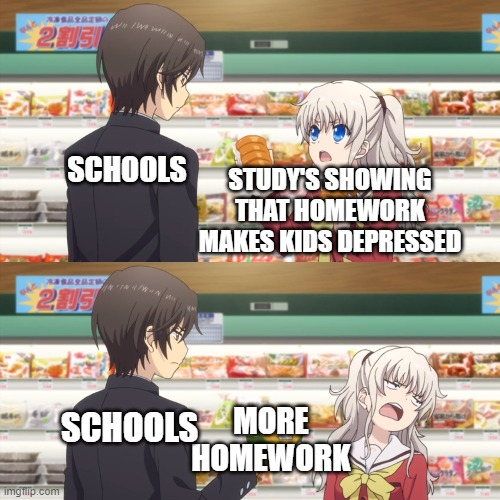

# Install dlt with duckdb extention

In [ ]:
%%capture
!pip install dlt[duckdb]

# Play with API using requests library

In [ ]:
import requests
response = requests.get("https://api.jikan.moe/v4/anime")
response.json()["data"][0]

# Helper
Run the cell and ignore it.

In [ ]:
from dlt.common.pipeline import LoadInfo

def assert_load_info(info: LoadInfo, expected_load_packages: int = 1) -> None:
    """Asserts that expected number of packages was loaded and there are no failed jobs"""
    assert len(info.loads_ids) == expected_load_packages
    # all packages loaded
    assert all(package.state == "loaded" for package in info.load_packages) is True
    # no failed jobs in any of the packages
    info.raise_on_failed_jobs()

# Task 1


- Create a pipeline for the API, for the next endpoints:
  - anime;
  - characters.

- Fill the empty lines in the functions below.
- Create a [resource](https://dlthub.com/docs/general-usage/resource#declare-a-resource) for the `characters` endpoint from scratch.
- Group them in `dlt.source`.
- [Run the pipeline](https://dlthub.com/docs/walkthroughs/run-a-pipeline) without errors.

In [ ]:
import time

import dlt
import requests


@dlt.resource(table_name="anime")
def get_anime():
    # put your code here


# put your code here


pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

load_info = pipeline.run(# put your code here)
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info)

Run the code below and
## Answer the Questions:
**1.1** How many tables were generated by dlt during the normalisation step (see "Normalized data for the following tables:")? Including tables created by dlt (e.g. `_dlt_pipeline_state`).

**1.2** What anime has the highest score?

In [ ]:
print(len(pipeline.last_trace.last_normalize_info.asdict()["load_packages"][0]["jobs"]))

Look at the data:

In [ ]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT title_english, score FROM anime ORDER BY score DESC LIMIT 6;").df()
display(stats_table)

You could notice that we received only 1 page, only 25 records. But this endpoint has over 27k records in total (see below). To get all the pages you should use a pagination.

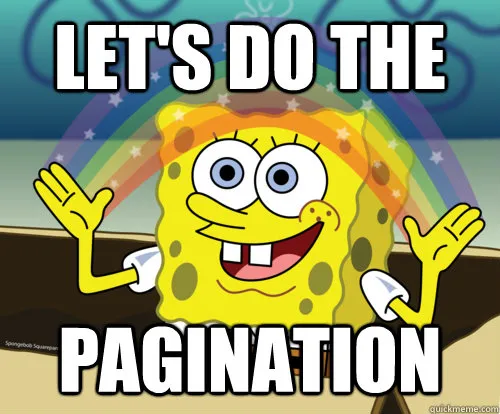

# Pagination

Play with requests, check out what pagination parameters you can use.

In [ ]:
import requests
response = requests.get("https://api.jikan.moe/v4/anime")
response.json()['pagination']

We can see that this endpoint has 27298 items in total.

Let's load only new anime released (with status "airing") in the last 3 month:

In [ ]:
params = {
    "order_by": "start_date",
    "start_date": "2024-07-01",
    "status": "airing",
    "page": 1
}

response = requests.get("https://api.jikan.moe/v4/anime", params=params)
print(response.json()["pagination"])
print(response.json()["data"][0])

# Task 2
- Add [pagination](https://www.getknit.dev/blog/api-pagination-best-practices) for endpoint `anime`.
- Add incremental loading for the resource `anime`. Use:
  - `aired.from` as a cursor,
  - `merge` write disposition,
  - `mal_id` as a  primary key.
  - `dlt.sources.incremental`,
  - "2024-07-01T00:00:00+00:00" as `initial_value`.

- Run the pipeline without errors.

Read more about [incremental loading](https://dlthub.com/docs/general-usage/incremental-loading).


WARNING: This API has [Rate Limits](https://docs.api.jikan.moe/#section/Information/Rate-Limiting). Try to reduce the number of pages during the development.

In [ ]:
import time
import dlt
import requests


@dlt.resource(# put your code here)
def get_anime(
    aired_from=# put your code here
):
    # put your code here



pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

load_info = pipeline.run(get_anime())
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info)


load_info = pipeline.run(get_anime())
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info, expected_load_packages=0)


## Answer the Questions:
**2.1.**  How many rows has `anime__titles` table?

**2.2** What anime has the highest score now?

In [ ]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT title_english, score FROM anime ORDER BY score DESC LIMIT 4;").df()
display(stats_table)

# Task 3: Get reviews with dlt.transformer

- Use `@dlt.transformer` to get additional info for your data.

- Use endpoint `anime/{id}/reviews` to get reviews for anime endpoint from task 1 (one page, without pagination and incremental loading).
- Don't forget to handle Rate Limits errors.
- Run pipeline without errors.

Read more about dlt [transformers](https://dlthub.com/docs/general-usage/resource#process-resources-with-dlttransformer).

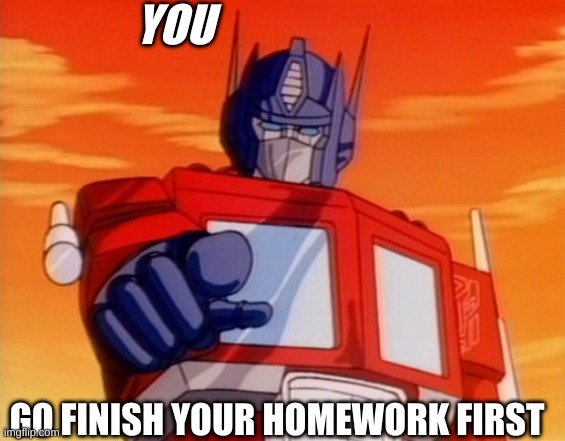

In [ ]:
import time
import dlt
import requests


def get_anime():
    # put your code here



def get_reviews(items):
    # put your code here



pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data_tr',
    dev_mode=True,
)

data = get_anime | get_reviews

load_info = pipeline.run(data())
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info)

Run the code below and

## Answer the Questions:

**3.1** How many tables were generated by dlt during the normalisation step (see "Normalized data for the following tables:")? Including tables created by dlt (e.g. `_dlt_pipeline_state`).

**3.2** Which username got the most overall reactions?

In [ ]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
# list all tables
display(conn.sql("DESCRIBE"))

stats_table = conn.sql("SELECT user__username, reactions__overall, review FROM anime_reviews ORDER BY reactions__overall DESC LIMIT 5;").df()
print(stats_table.columns)
display(stats_table)

# Bonus
There are no tasks, just a top 5 Anime according to
 MyAnimeList database 😉

In [ ]:
import time

import dlt
import requests


@dlt.resource(table_name="top_anime")
def get_top_anime():
    response = requests.get("https://api.jikan.moe/v4/top/anime")
    yield response.json()["data"]


pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

load_info = pipeline.run(get_top_anime())
print(load_info)
print(pipeline.last_trace.last_normalize_info)


In [ ]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT title_english, score FROM top_anime ORDER BY score DESC LIMIT 5;").df()
display(stats_table)